In [39]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
import time
import random
import glob

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image
from torchvision.models import resnet152
from torchvision.transforms import v2
from torch.utils.data import DataLoader


# seed
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [40]:
# model
model = resnet152(pretrained=True)
model = nn.DataParallel(model)
model.to(device)

# data
img_paths = glob.glob("./data/Zeiler-Fergus/*")
labels = [366, 355, 312, 261, 298]

In [41]:
model

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [42]:
'''課題4 
CAM
'''

img_idx = 4
o_img = read_image(img_paths[img_idx])
label = labels[img_idx]

In [43]:
class CAM():
    def __init__(self, model):
        self.model = model.eval()
        self.softmax = nn.Softmax(dim=1)
        
    feature_maps = None
    def forward_hook(self, module, ipt, out):
        global feature_maps
        feature_maps = out.detach()

    def generate(self, input_tensor, target_class):
        # フック登録
        target_layer = self.model.module.layer4[-1].conv3
        handle = target_layer.register_forward_hook(self.forward_hook)

        with torch.no_grad():
            logits = model(input_tensor)
        # class_idx = self.softmax(logits).argmax(dim=1).item()

        # 重み取得
        weights = model.module.fc.weight
        w_c = weights[target_class]

        # feature map
        fm = feature_maps.squeeze(0)
        weighted_fm = w_c.view(-1, 1, 1) * fm
        cam = weighted_fm.sum(dim=0)

        # 論文にてReLU適用している．正に寄与している空間位置を可視化したい
        cam = cam.clamp(min=0.0)
        # 正規化
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        # 4Dに変換してリサイズ（F.interpolateは4次元想定）
        cam_tensor = cam.unsqueeze(0).unsqueeze(0) 
        cam_resized = F.interpolate(
            cam_tensor,
            size=(256,256),
            mode='bilinear',
            align_corners=False
        )   
        cam_resized = cam_resized[0,0].detach().cpu().numpy()

        return cam_resized
        

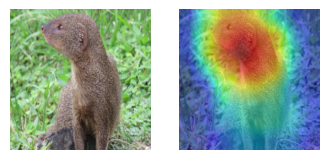

In [44]:
# ex
# exp
transform_1 = v2.Compose([
    v2.Resize([256, 256]),
    v2.ToDtype(torch.float, scale=True),
])
transform_2 = v2.Compose([
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img_1 = transform_1(o_img)
img_2 = transform_2(img_1).unsqueeze(0)
img_2.to(device)

cam = CAM(model)
out_map = cam.generate(img_2, label)

plt.figure(figsize=(4,4))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(img_1.permute(1,2,0))

plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(img_1.permute(1,2,0))
plt.imshow(out_map, cmap='jet', alpha=0.5, vmin=0, vmax=1)